# PCA con los datos de arrestos por estado en USA

Vamos a utilizar una pequeña base de datos que describe la cantidad de arrestos en cada uno de los estados de USA. La unidad de estudio es entonces cada estado de USA, que se describen a partir de las siguientes variables:
- Murder: cantidad de arrestos por asesinato
- Assault: cantidad de arrestos por asalto
- Rape: cantidad de arrestos por violación
- UrbanPop: identifica el porcentaje de población urbana de cada estado 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Carga y entendimiento de los datos

Cargamos los datos

In [12]:
df = pd.read_csv('05-USArrests.csv', index_col=0)
print(df.shape)
df.head(5)

(50, 4)


,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Vamos a cambiar la variable State, para que sea el índice de las instancias de cada fila.

In [13]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


Vemos que el dataset esta completo, que los valores son todos numéricos.
También podemos percibir que el número de asaltos es mucho más elevado que el de asesinatos, presentado además una desviación estándar bien importante con respecto a las otras variables numéricas.

De hecho, cuando calculamos las varianzas de las variables encontramos lo siguiente:

In [15]:
np.var(df)

Murder        18.591056
Assault     6806.262400
UrbanPop     205.328400
Rape          85.974576
dtype: float64

La variable "Assault" es responsable por la mayoría de la varianza del dataset. Es el atributo que aportaría mayor información en caso de no normalizar los datos.

## Proyección sobre el espacio de representación de los componentes principales

In [16]:
pca = PCA()
df_proyectado = pca.fit_transform(df)

Una vez ajustado el objeto PCA a un dataset, este permite acceder a diferentes aspectos resultantes de la transformación:
- **components_**: los ejes de los componentes principales en función de las variables originales. Como teníamos 4 variables, vamos a tener 4 PCs, cada uno con las cargas (*loadings*) correspondientes a cada variable original (4 variables originales).

In [17]:
pca.components_

array([[ 0.04170432,  0.99522128,  0.04633575,  0.0751555 ],
       [-0.04482166, -0.05876003,  0.97685748,  0.20071807],
       [ 0.07989066, -0.06756974, -0.20054629,  0.97408059],
       [ 0.99492173, -0.0389383 ,  0.05816914, -0.07232502]])

In [18]:
df.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

Analicemos los aportes de cada variable original a cada componente principal:
- Podemos ver que el primer componente principal PC1 tiene una participación positiva muy importante de la segunda variable original, con un loading de 0.9952 asociado a "Assault". Esto se puede interpretar como que PC1 es casi que una copia de Assault; a mayores valores de Assault, mayor valor del PC1
- El segundo PC esta sobretodo caracterizado por el aporte negativo de la tercera variable (UrbaPop); a mayor valor de UrbanPop, menor valor de PC2
- PC3 se caracteriza por tener una carga importante asociada a la cuarta variable (Rape)
- PC4 se caracteriza por tener una carga importante asociada a la primera variable (Murder)

En realidad en este primer intento cada PC esta asociado sobretodo a una de las variables originales.

- **explained_variance_**: la varianza explicada por cada eje en las unidades originales

In [19]:
pca.explained_variance_

array([7.01111485e+03, 2.01992366e+02, 4.21126508e+01, 6.16424618e+00])

- **explained_variance_ratio_**: la proporción de la varianza explicada por cada eje, en porcentaje (la suma da 100%).

In [20]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

array([9.65534221e-01, 2.78173366e-02, 5.79953492e-03, 8.48907879e-04])

El objeto PCA sirve además para pasar de la representación en las dimensiones originales a la de las dimensiones en el espacio de los componentes principales encontrados, a partir de su método transform:

In [21]:
dataPca = pca.transform(df)

Veamos gráficamente la cantidad de información correspondiente a cada componente principal:

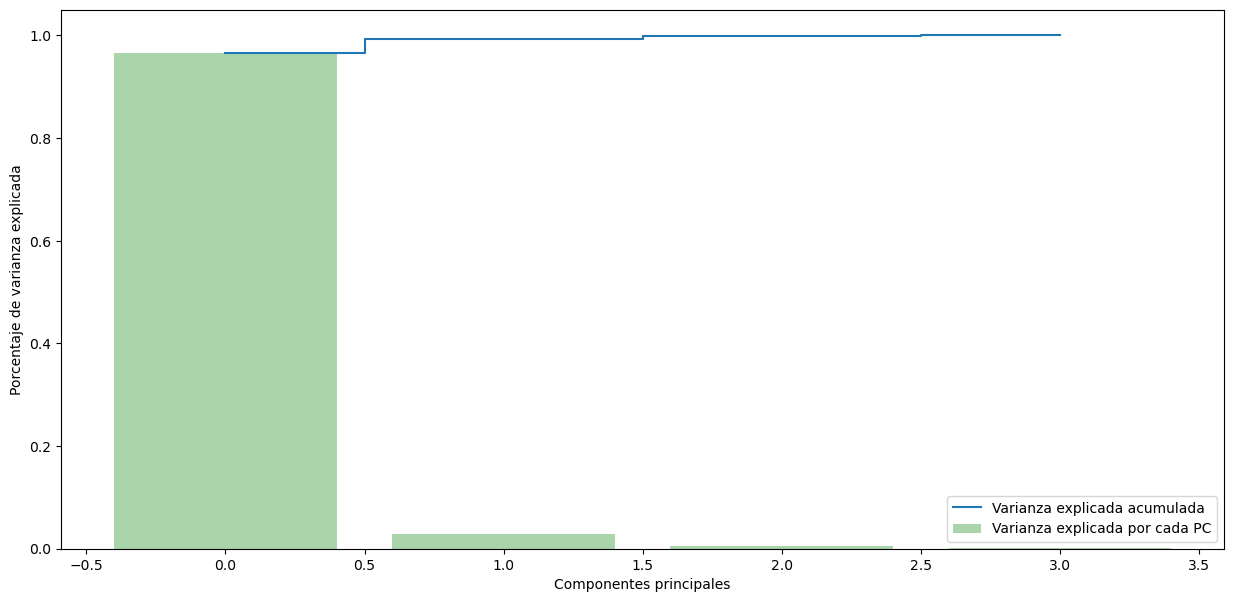

In [22]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

In [23]:
pca.explained_variance_ratio_

array([9.65534221e-01, 2.78173366e-02, 5.79953492e-03, 8.48907879e-04])

Podemos ver que PC1 representa por sí solo el 96.5% de la información. Recordemos que este PC estaba asociado a la variable Assault, que era la que originalmente tenía la mayor proporción de información.

En realidad, el proceso que acabamos de realizar está viciado, en el sentido de que no normalizamos los datos, dándole más importancia a la variable con valores de mayor escala (Assault).

Vamos entonces a corregir el proceso, estandarizando los datos.

In [24]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(df)
print(scaler.mean_)

[  7.788 170.76   65.54   21.232]


In [25]:
df_std = scaler.transform(df)

In [26]:
pca = PCA()
df_proyectado = pca.fit_transform(df_std)

Una vez ajustado el objeto PCA a un dataset, este permite acceder a diferentes aspectos resultantes de la transformación:
- **components_**: los ejes de los componentes principales en función de las variables originales. Como teníamos 64 variables, vamos a tener 64 PCs, cada uno con las cargas (*loadings*) correspondientes a cada variable original (64 variables originales).

In [27]:
pca.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

In [28]:
df.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

Analicemos los aportes de cada variable original a cada componente principal:
- PC1 tiene una participación positiva fuerte de las tres variables asociadas a los 3 tipos de crímenes, por lo que podemos interpretar esta nueva variable como un "índice de criminalidad".
- PC2 esta sobretodo caracterizado por el aporte negativo importante de la tercera variable (UrbaPop); a mayor valor de UrbanPop, menor valor de PC2
- PC3 se caracteriza por tener una carga importante asociada a Rape
- PC4 se caracteriza por tener una carga importante asociada a Murder y Asalto

In [29]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

In [30]:
np.sum(pca.explained_variance_ratio_[0:2])

0.8675016829223337

Encontramos que PC1 representa el 62% de la varianza y que PC2 el 24.7%. Entre estos dos componentes tenemos entonces el 86.7% de la información.

In [31]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

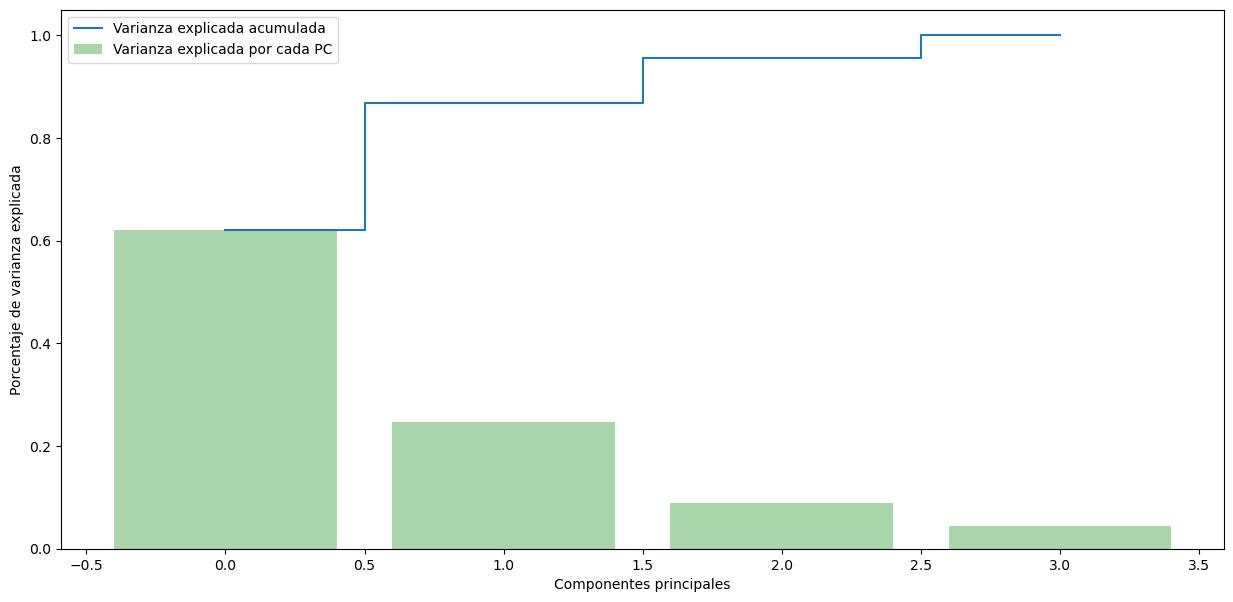

In [32]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

Visualicemos los datos proyectados sobre los dos primeros componentes principales, para entender mejor el dataset en su nueva representación.

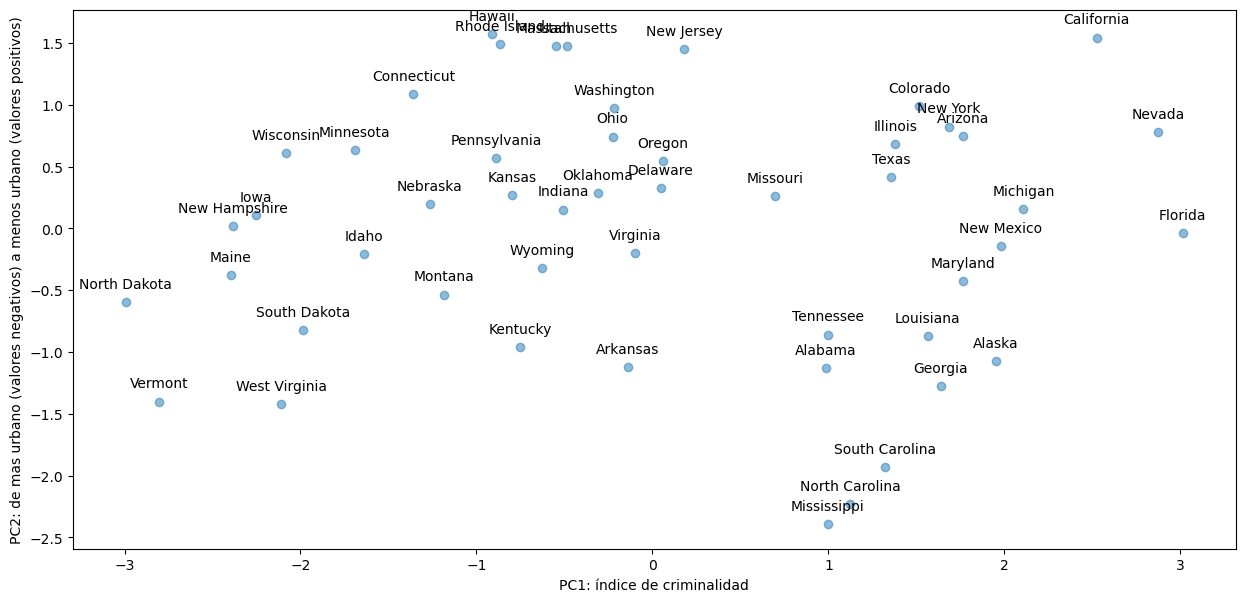

In [33]:
plt.figure(figsize=(15, 7))
plt.scatter(df_proyectado[:, 0], df_proyectado[:, 1], alpha=0.5)
plt.xlabel('PC1: índice de criminalidad')
plt.ylabel('PC2: de mas urbano (valores negativos) a menos urbano (valores positivos)')
for x,y,label in zip(df_proyectado[:, 0], df_proyectado[:, 1], df.index):
    plt.annotate(label,
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

Vamos a ver los puntos en el nuevo sistema de representación dado por los componentes principales.
Creamos una función que permite plotear tanto los puntos de los datos como los loadings de las variables originales (tomada de https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot).
Esto nos permitirá entender mejor la relación entre componentes principales y variables originales.

In [34]:
def biplot(data, loadings, index1, index2, labels=None, point_labels=None):
    plt.figure(figsize=(15, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1]*.8, loadings[i,index2]*.8,color='r',alpha=0.5)
        if labels is None:
            plt.text(loadings[i,index1]*.85, loadings[i,index2]*.85, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(loadings[i,index1]*.85, loadings[i,index2]*.85, labels[i], color='g', ha='center', va='center')
    for x,y,label in zip(xs*scalex, ys*scaley, point_labels):
        plt.annotate(label,
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1+1))
    plt.ylabel("PC{}".format(index2+1))
    plt.grid() 

Veamos como nos va con los primeros dos componentes principales:

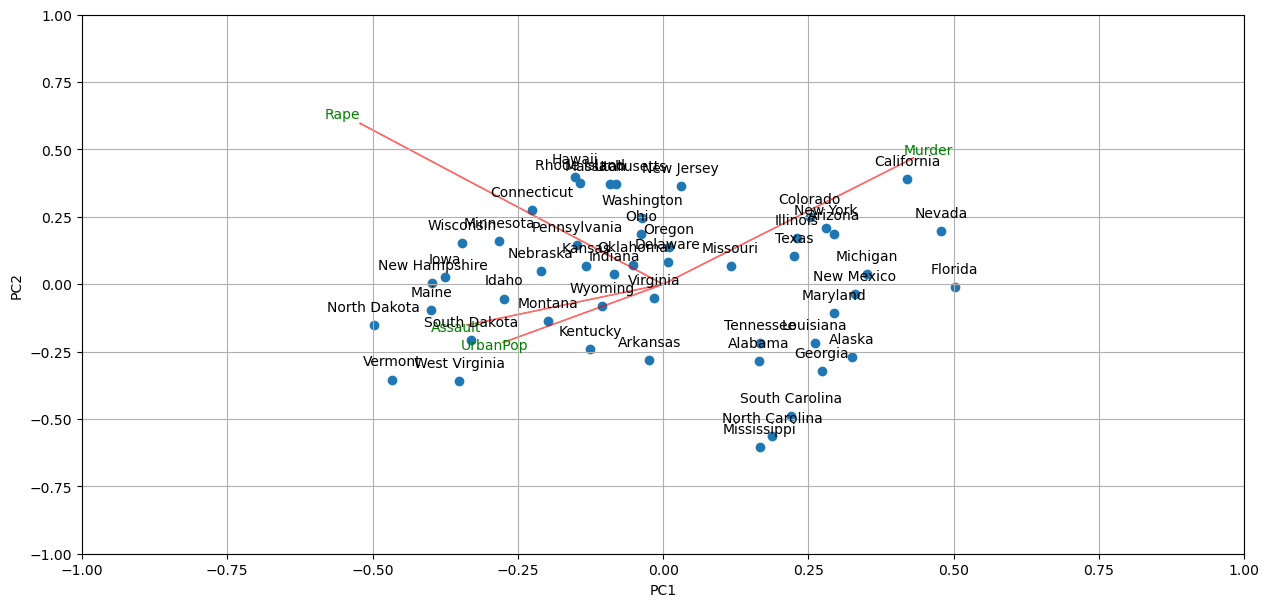

In [35]:
biplot(df_proyectado, pca.components_, 0, 1, df.columns, df.index)

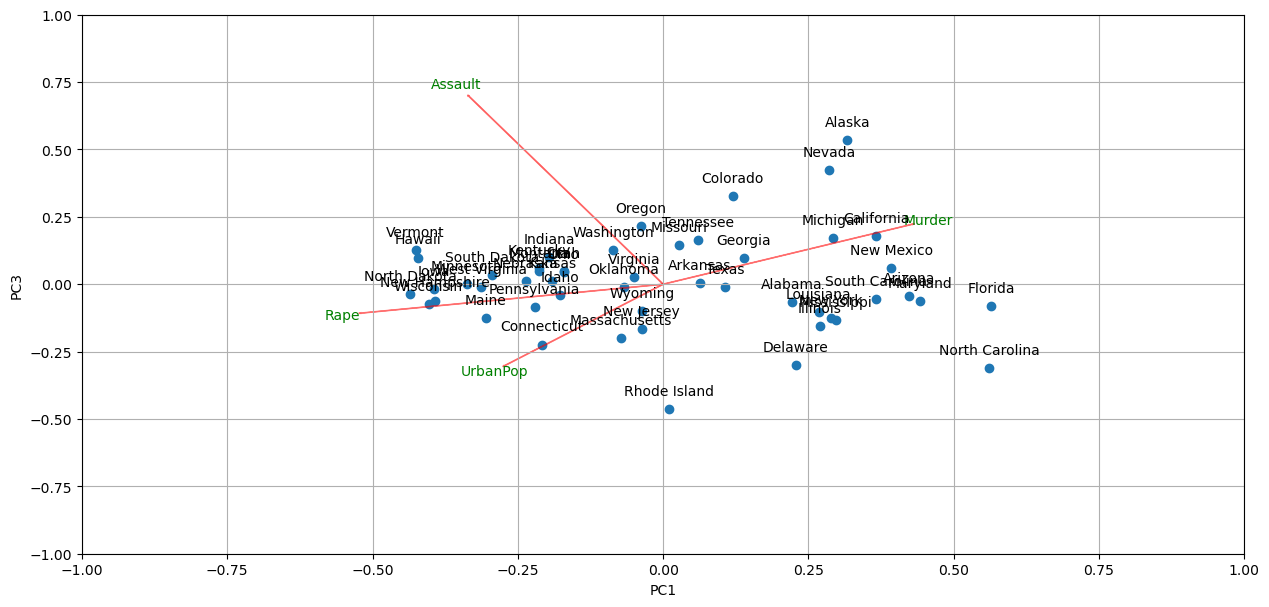

In [36]:
biplot(dataPca, pca.components_, 0, 2, df.columns, df.index)